# This notebook has been written in accordance to my blog post on medium, feel free to read in this [Link](https://medium.com/towards-artificial-intelligence/create-your-own-mini-word-embedding-from-scratch-c7b32bd84f8e) to get the complete essence of it.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import random
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
!pip install torchsummaryX  --quiet
from torchsummaryX import summary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


![image.png](https://github.com/bala-codes/Mini_Word_Embeddings/blob/master/codes/untrained%20to%20trained.PNG?raw=true)

# Data - Preprocessing - Steps : Visualization

<img src="https://cdn-images-1.medium.com/max/1200/0*dEB7_sqWOHhV82EI.png">

# Dataset Source
<img src="https://github.com/bala-codes/Mini_Word_Embeddings/blob/master/codes/Capture.PNG?raw=true">


<img src="https://cdn-images-1.medium.com/max/800/1*SANI-0E8qSTHzGHg4HHtNA.png">


In [2]:
# Sample Document # Recreated from the tom and jerry cartoon
        
docs = ["cat and mice are buddies",
        'mice lives in hole',
        'cat lives in house',
        'cat chases mice',
        'cat catches mice',
        'cat eats mice',
        'mice runs into hole',
        'cat says bad words',
        'cat and mice are pals',
        'cat and mice are chums',
        'mice stores food in hole',
        'cat stores food in house',
        'mice sleeps in hole',
        'cat sleeps in house']

In [3]:
idx_2_word = {}
word_2_idx = {}
temp = []
i = 1
for doc in docs:
    for word in doc.split():
        if word not in temp:
            temp.append(word)
            idx_2_word[i] = word
            word_2_idx[word] = i
            i += 1

print(idx_2_word)
print(word_2_idx)

{1: 'cat', 2: 'and', 3: 'mice', 4: 'are', 5: 'buddies', 6: 'lives', 7: 'in', 8: 'hole', 9: 'house', 10: 'chases', 11: 'catches', 12: 'eats', 13: 'runs', 14: 'into', 15: 'says', 16: 'bad', 17: 'words', 18: 'pals', 19: 'chums', 20: 'stores', 21: 'food', 22: 'sleeps'}
{'cat': 1, 'and': 2, 'mice': 3, 'are': 4, 'buddies': 5, 'lives': 6, 'in': 7, 'hole': 8, 'house': 9, 'chases': 10, 'catches': 11, 'eats': 12, 'runs': 13, 'into': 14, 'says': 15, 'bad': 16, 'words': 17, 'pals': 18, 'chums': 19, 'stores': 20, 'food': 21, 'sleeps': 22}


# Words to numbers

In [4]:
vocab_size = 25

def one_hot_map(doc):
    x = []
    for word in doc.split():
        x.append(word_2_idx[word])
    return x
  
encoded_docs = [one_hot_map(d) for d in docs]
encoded_docs

[[1, 2, 3, 4, 5],
 [3, 6, 7, 8],
 [1, 6, 7, 9],
 [1, 10, 3],
 [1, 11, 3],
 [1, 12, 3],
 [3, 13, 14, 8],
 [1, 15, 16, 17],
 [1, 2, 3, 4, 18],
 [1, 2, 3, 4, 19],
 [3, 20, 21, 7, 8],
 [1, 20, 21, 7, 9],
 [3, 22, 7, 8],
 [1, 22, 7, 9]]

# Padding

In [5]:
max_len = 10
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
padded_docs

array([[ 1,  2,  3,  4,  5,  0,  0,  0,  0,  0],
       [ 3,  6,  7,  8,  0,  0,  0,  0,  0,  0],
       [ 1,  6,  7,  9,  0,  0,  0,  0,  0,  0],
       [ 1, 10,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 11,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 12,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 3, 13, 14,  8,  0,  0,  0,  0,  0,  0],
       [ 1, 15, 16, 17,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  3,  4, 18,  0,  0,  0,  0,  0],
       [ 1,  2,  3,  4, 19,  0,  0,  0,  0,  0],
       [ 3, 20, 21,  7,  8,  0,  0,  0,  0,  0],
       [ 1, 20, 21,  7,  9,  0,  0,  0,  0,  0],
       [ 3, 22,  7,  8,  0,  0,  0,  0,  0,  0],
       [ 1, 22,  7,  9,  0,  0,  0,  0,  0,  0]], dtype=int32)

# Creating dataset tuples for training

In [6]:
training_data = np.empty((0,2))

window = 2
for sentence in padded_docs:
    sent_len = len(sentence)
    
    for i, word in enumerate(sentence):
        w_context = []
        if sentence[i] != 0:
            w_target = sentence[i]
            for j in range(i-window, i + window + 1):
                if j != i and j <= sent_len -1 and j >=0 and sentence[j]!=0:
                    w_context = sentence[j]
                    training_data = np.append(training_data, [[w_target, w_context]], axis=0)

print(len(training_data))
print(training_data.shape)
training_data

148
(148, 2)


array([[ 1.,  2.],
       [ 1.,  3.],
       [ 2.,  1.],
       [ 2.,  3.],
       [ 2.,  4.],
       [ 3.,  1.],
       [ 3.,  2.],
       [ 3.,  4.],
       [ 3.,  5.],
       [ 4.,  2.],
       [ 4.,  3.],
       [ 4.,  5.],
       [ 5.,  3.],
       [ 5.,  4.],
       [ 3.,  6.],
       [ 3.,  7.],
       [ 6.,  3.],
       [ 6.,  7.],
       [ 6.,  8.],
       [ 7.,  3.],
       [ 7.,  6.],
       [ 7.,  8.],
       [ 8.,  6.],
       [ 8.,  7.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 6.,  1.],
       [ 6.,  7.],
       [ 6.,  9.],
       [ 7.,  1.],
       [ 7.,  6.],
       [ 7.,  9.],
       [ 9.,  6.],
       [ 9.,  7.],
       [ 1., 10.],
       [ 1.,  3.],
       [10.,  1.],
       [10.,  3.],
       [ 3.,  1.],
       [ 3., 10.],
       [ 1., 11.],
       [ 1.,  3.],
       [11.,  1.],
       [11.,  3.],
       [ 3.,  1.],
       [ 3., 11.],
       [ 1., 12.],
       [ 1.,  3.],
       [12.,  1.],
       [12.,  3.],
       [ 3.,  1.],
       [ 3., 12.],
       [ 3.,

<img src="https://cdn-images-1.medium.com/max/800/1*pDeswCr7eBhEDtiywMkAqQ.png">


<img src="https://cdn-images-1.medium.com/max/1200/1*r_9zfDywyD1TbVpxKENHjw.png">

In [7]:
enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_x = enc.transform(training_data[:,0].reshape(-1,1)).toarray()
onehot_label_x

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
enc = OneHotEncoder()
enc.fit(np.array(range(30)).reshape(-1,1))
onehot_label_y = enc.transform(training_data[:,1].reshape(-1,1)).toarray()
onehot_label_y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
print(onehot_label_x[0])
print(onehot_label_y[0])

# From Numpy to Torch

onehot_label_x = torch.from_numpy(onehot_label_x)
onehot_label_y = torch.from_numpy(onehot_label_y)
print(onehot_label_x.shape, onehot_label_y.shape)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
torch.Size([148, 30]) torch.Size([148, 30])


<img src="https://cdn-images-1.medium.com/max/800/1*rb9i3dT_rH3DB31atto_Ag.png">

In [10]:
class WEMB(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WEMB, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.softmax = nn.Softmax(dim=1)
    
        self.l1 = nn.Linear(self.input_size, self.hidden_size, bias=False)
        self.l2 = nn.Linear(self.hidden_size, self.input_size, bias=False)
   
    def forward(self, x):
        out_bn = self.l1(x) # bn - bottle_neck
        out = self.l2(out_bn)
        out = self.softmax(out)
        return out, out_bn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
'''
m = nn.Softmax() #nn.Sigmoid()
loss = nn.BCELoss()
input = torch.tensor([0.9,0.0,0.0]) #torch.randn(3, requires_grad=True)
target = torch.tensor([1.0,0.0,0.0])
output = loss(m(input), target)
print(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.5515, 0.2242, 0.2242]) tensor([1., 0., 0.])
output -> 0.36
'''

'''
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.tensor([0.9,0.0,0.0])
target = torch.tensor([1.0,0.0,0.0])
output = loss(m(input), target)
print(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.7109, 0.5000, 0.5000]) tensor([1., 0., 0.])
output -> 0.5758
'''

'\nm = nn.Sigmoid()\nloss = nn.BCELoss()\ninput = torch.tensor([0.9,0.0,0.0])\ntarget = torch.tensor([1.0,0.0,0.0])\noutput = loss(m(input), target)\nprint(input, m(input), target) tensor([0.9000, 0.0000, 0.0000]) tensor([0.7109, 0.5000, 0.5000]) tensor([1., 0., 0.])\noutput -> 0.5758\n'

In [12]:
input_size = 30
hidden_size = 2
learning_rate = 0.01
num_epochs = 5000

untrained_model = WEMB(input_size, hidden_size).to(device)
model = WEMB(input_size, hidden_size).to(device)
model.train(True)
print(model)
print()

# Loss and optimizer
criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)
summary(model, torch.ones((1,30)).to(device)) 

WEMB(
  (softmax): Softmax(dim=1)
  (l1): Linear(in_features=30, out_features=2, bias=False)
  (l2): Linear(in_features=2, out_features=30, bias=False)
)

          Kernel Shape Output Shape Params Mult-Adds
Layer                                               
0_l1           [30, 2]       [1, 2]   60.0      60.0
1_l2           [2, 30]      [1, 30]   60.0      60.0
2_softmax            -      [1, 30]      -         -
------------------------------------------------------
                      Totals
Total params           120.0
Trainable params       120.0
Non-trainable params     0.0
Mult-Adds              120.0


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_l1,"[30, 2]","[1, 2]",60.0,60.0
1_l2,"[2, 30]","[1, 30]",60.0,60.0
2_softmax,-,"[1, 30]",NaN,NaN


Epoch [100/5000], Loss: 0.1472
Epoch [200/5000], Loss: 0.1457
Epoch [300/5000], Loss: 0.1439
Epoch [400/5000], Loss: 0.1414
Epoch [500/5000], Loss: 0.1376
Epoch [600/5000], Loss: 0.1323
Epoch [700/5000], Loss: 0.1250
Epoch [800/5000], Loss: 0.1161
Epoch [900/5000], Loss: 0.1060
Epoch [1000/5000], Loss: 0.0956
Epoch [1100/5000], Loss: 0.0857
Epoch [1200/5000], Loss: 0.0766
Epoch [1300/5000], Loss: 0.0688
Epoch [1400/5000], Loss: 0.0624
Epoch [1500/5000], Loss: 0.0574
Epoch [1600/5000], Loss: 0.0536
Epoch [1700/5000], Loss: 0.0508
Epoch [1800/5000], Loss: 0.0487
Epoch [1900/5000], Loss: 0.0471
Epoch [2000/5000], Loss: 0.0459
Epoch [2100/5000], Loss: 0.0451
Epoch [2200/5000], Loss: 0.0445
Epoch [2300/5000], Loss: 0.0440
Epoch [2400/5000], Loss: 0.0437
Epoch [2500/5000], Loss: 0.0436
Epoch [2600/5000], Loss: 0.0434
Epoch [2700/5000], Loss: 0.0434
Epoch [2800/5000], Loss: 0.0434
Epoch [2900/5000], Loss: 0.0433
Epoch [3000/5000], Loss: 0.0433
Epoch [3100/5000], Loss: 0.0433
Epoch [3200/5000]

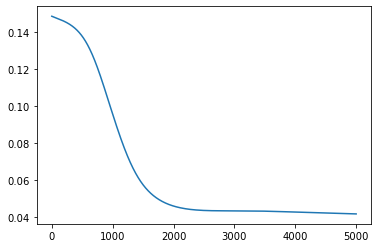

In [13]:
loss_val = []
onehot_label_x = onehot_label_x.to(device)
onehot_label_y = onehot_label_y.to(device)

for epoch in range(num_epochs):
    for i in range(onehot_label_y.shape[0]):
        inputs = onehot_label_x[i].float()
        labels = onehot_label_y[i].float()
        inputs = inputs.unsqueeze(0)
        labels = labels.unsqueeze(0)

      # Forward pass
        output, wemb = model(inputs)
        loss = criterion(output, labels)

      # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_val.append(loss.item())

    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_val)

In [14]:
docs = ['cat and mice are buddies hole lives in house chases catches runs into says bad words pals chums stores sleeps']
encoded_docs = [one_hot_map(d) for d in docs]

test_arr = np.array([[ 1.,  2., 3., 4., 5., 8., 6., 7., 9., 10., 11., 13., 14., 15., 16., 17., 18., 19., 20., 22.]])
test = enc.transform(test_arr.reshape(-1,1)).toarray()

output = []
for i in range(test.shape[0]):
    _, wemb2 = model(torch.from_numpy(test[i]).unsqueeze(0).float().to(device))
    wemb2 = wemb2[0].detach().cpu().numpy()
    output.append(wemb2)
print(len(output))
print(output)

20
[array([-0.24298598,  0.5537579 ], dtype=float32), array([-0.8633791,  1.8984656], dtype=float32), array([-0.24893269,  0.549828  ], dtype=float32), array([2.0896878, 1.7328428], dtype=float32), array([-0.02455806,  1.7074513 ], dtype=float32), array([-1.8902676, -1.4941236], dtype=float32), array([-2.2949157,  1.2663206], dtype=float32), array([-1.3506931 ,  0.67496985], dtype=float32), array([-2.4845347, -0.8090527], dtype=float32), array([-0.7694416,  1.8697813], dtype=float32), array([-0.810355 ,  1.8848215], dtype=float32), array([-0.68450063,  0.60070586], dtype=float32), array([-0.69886106,  0.5470873 ], dtype=float32), array([0.20886244, 0.12920803], dtype=float32), array([0.26691765, 0.18339959], dtype=float32), array([ 0.19229932, -1.6974784 ], dtype=float32), array([-0.08495952,  1.7132046 ], dtype=float32), array([-0.05442476,  1.7049241 ], dtype=float32), array([-2.2940848,  1.1305262], dtype=float32), array([-2.2840753,  1.2602378], dtype=float32)]


In [15]:
docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', 'chums', 'stores', 'sleeps']
for i in range(0, len(docs)):
    print("Word - {} - It's Word Embeddings : {:.3} & {:.3} -".format(docs[i], output[i][0], output[i][0]))

Word - cat - It's Word Embeddings : -0.243 & -0.243 -
Word - and - It's Word Embeddings : -0.863 & -0.863 -
Word - mice - It's Word Embeddings : -0.249 & -0.249 -
Word - are - It's Word Embeddings : 2.09 & 2.09 -
Word - buddies - It's Word Embeddings : -0.0246 & -0.0246 -
Word - hole - It's Word Embeddings : -1.89 & -1.89 -
Word - lives - It's Word Embeddings : -2.29 & -2.29 -
Word - in - It's Word Embeddings : -1.35 & -1.35 -
Word - house - It's Word Embeddings : -2.48 & -2.48 -
Word - chases - It's Word Embeddings : -0.769 & -0.769 -
Word - catches - It's Word Embeddings : -0.81 & -0.81 -
Word - runs - It's Word Embeddings : -0.685 & -0.685 -
Word - into - It's Word Embeddings : -0.699 & -0.699 -
Word - says - It's Word Embeddings : 0.209 & 0.209 -
Word - bad - It's Word Embeddings : 0.267 & 0.267 -
Word - words - It's Word Embeddings : 0.192 & 0.192 -
Word - pals - It's Word Embeddings : -0.085 & -0.085 -
Word - chums - It's Word Embeddings : -0.0544 & -0.0544 -
Word - stores - It's

[-0.24298598, -0.8633791, -0.24893269, 2.0896878, -0.02455806, -1.8902676, -2.2949157, -1.3506931, -2.4845347, -0.7694416, -0.810355, -0.68450063, -0.69886106, 0.20886244, 0.26691765, 0.19229932, -0.08495952, -0.05442476, -2.2940848, -2.2840753] [0.5537579, 1.8984656, 0.549828, 1.7328428, 1.7074513, -1.4941236, 1.2663206, 0.67496985, -0.8090527, 1.8697813, 1.8848215, 0.60070586, 0.5470873, 0.12920803, 0.18339959, -1.6974784, 1.7132046, 1.7049241, 1.1305262, 1.2602378]


<Figure size 432x288 with 0 Axes>

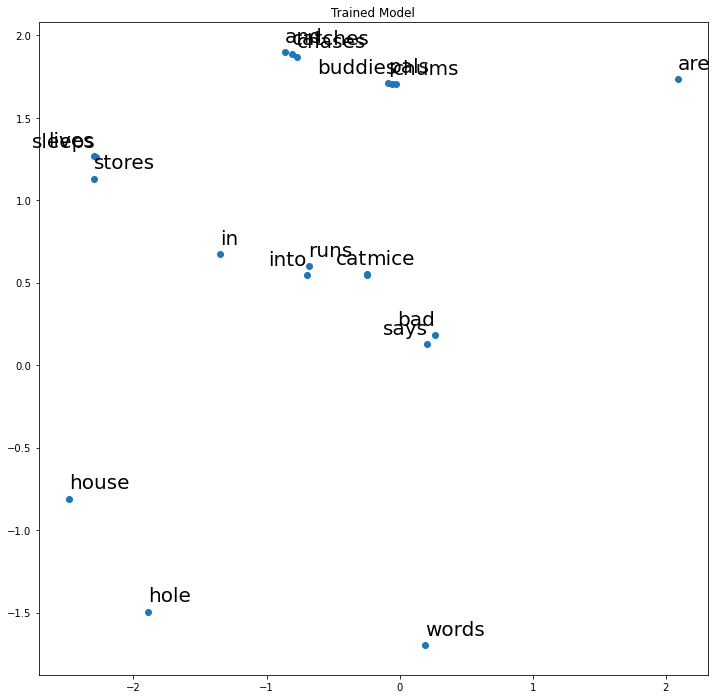

In [16]:
xs = []
ys = []
for i in range(len(output)):
    xs.append(output[i][0])
    ys.append(output[i][1])
print(xs, ys)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', \
        'chums', 'stores', 'sleeps']

plt.clf()
plt.figure(figsize=(12,12))
plt.scatter(xs,ys)
label = docs

for i,(x,y) in enumerate(zip(xs,ys)):
    plt.annotate(label[i], (x,y), textcoords="offset points", xytext=(0,10), fontsize=20, ha = random.choice(['left', 'right']))
    plt.title("Trained Model")
plt.show()

In [17]:
import plotly
import plotly.express as px

import plotly.express as px
fig = px.scatter(x=xs, y=ys, text=docs, size_max=100)
fig.update_traces(textposition= random.choice(['top center', 'bottom center','bottom left']))
fig.update_layout(height=800,title_text='Custom Word Embeddings')
fig.show()

# How Untrained Model behaves with our data

20
[array([-0.09240239,  0.01444094], dtype=float32), array([ 0.04676013, -0.08691085], dtype=float32), array([-0.06942298, -0.07442439], dtype=float32), array([-0.1466948 ,  0.10954732], dtype=float32), array([ 0.09534967, -0.01709136], dtype=float32), array([0.037129, 0.126654], dtype=float32), array([ 0.12467006, -0.06700411], dtype=float32), array([0.06180859, 0.08317718], dtype=float32), array([-0.05503708,  0.01023227], dtype=float32), array([-0.092917  ,  0.17815298], dtype=float32), array([0.01381052, 0.01736981], dtype=float32), array([-0.01874311, -0.09409641], dtype=float32), array([-0.09335671,  0.12868339], dtype=float32), array([ 0.13756526, -0.06905542], dtype=float32), array([-0.03866081,  0.14400142], dtype=float32), array([-0.03424411,  0.16482219], dtype=float32), array([-0.0729035, -0.010795 ], dtype=float32), array([-0.0190572 , -0.00341165], dtype=float32), array([ 0.08595425, -0.16109653], dtype=float32), array([-0.15060022,  0.12472749], dtype=float32)]
[-0.0924

<Figure size 432x288 with 0 Axes>

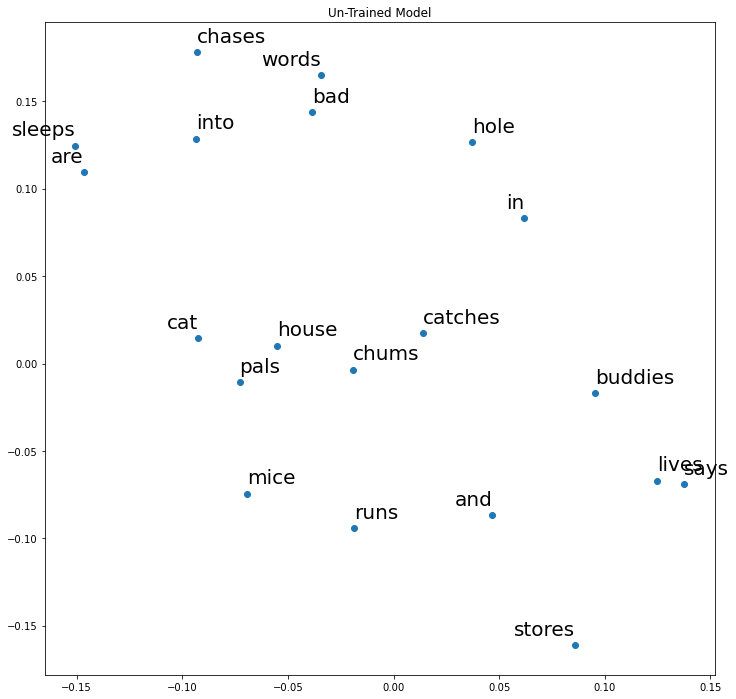

In [18]:
output = []
for i in range(test.shape[0]):
    _, wemb2 = untrained_model(torch.from_numpy(test[i]).unsqueeze(0).float().to(device)) # Here I am loading the untrained model
    wemb2 = wemb2[0].detach().cpu().numpy()
    output.append(wemb2)
print(len(output))
print(output)

xs = []
ys = []
for i in range(len(output)):
    xs.append(output[i][0])
    ys.append(output[i][1])
print(xs, ys)

docs = ['cat', 'and', 'mice', 'are', 'buddies', 'hole', 'lives', 'in', 'house', 'chases', 'catches', 'runs', 'into', 'says', 'bad', 'words', 'pals', \
        'chums', 'stores', 'sleeps']

plt.clf()
plt.figure(figsize=(12,12))
plt.scatter(xs,ys)
label = docs

for i,(x,y) in enumerate(zip(xs,ys)):
    plt.annotate(label[i], (x,y), textcoords="offset points", xytext=(0,10), fontsize=20, ha = random.choice(['left', 'right']))
    plt.title("Un-Trained Model")
plt.show()

In [19]:
import plotly
import plotly.express as px

import plotly.express as px
fig = px.scatter(x=xs, y=ys, text=docs, size_max=100)
fig.update_traces(textposition= random.choice(['top center', 'bottom center','bottom left']))
fig.update_layout(height=800,title_text='Custom Word Embeddings')
fig.show()